<a href="https://colab.research.google.com/github/tejasspawar/cv/blob/master/Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Important Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Mount Drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


**Import Data Set**

In [ ]:
keywords = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/keywords.csv') 
metadata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movies_metadata.csv') 
credits = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/credits.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings.csv')

In [ ]:
data_names = ['credits', 'keywords', 'metadata', 'ratings']
count = 0

# for each imported dataset display head of the data
for data in [credits, keywords, metadata, ratings]:
    print('\n\n\n\033[33mHead of the', data_names[count] , 'data\033[0m')
    display(data.head())
    print(data.shape)
    count += 1




Head of the credits data


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


(45476, 3)



Head of the keywords data


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


(46419, 2)



Head of the metadata data


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


(45466, 24)



Head of the ratings data


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


(26024289, 4)


In [ ]:
print(metadata.id.dtypes) # id types needs to be converted into integer

object


In [ ]:
metadata2 = metadata 
# Some of the data points in id column have dates insted of id so replace those id with NaN
metadata2['id'] = metadata2['id'].apply(lambda x: x if len(x.split('-'))==1 else np.nan)

In [ ]:
metadata2.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           3
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [ ]:
metadata3 = metadata2.dropna(subset=['id'])
metadata3 = metadata3.drop('imdb_id', axis=1)

In [ ]:
ratings_column_renamed = ratings.rename(index=str, columns={'movieId':'id'})
metadata3['id'] = metadata3['id'].astype(int)
#merged = ratings_column_renamed.merge(metadata3, on='id')
data = metadata3.merge(keywords, on='id')
data = data.merge(credits, on='id')

# **Data Pre Processing**

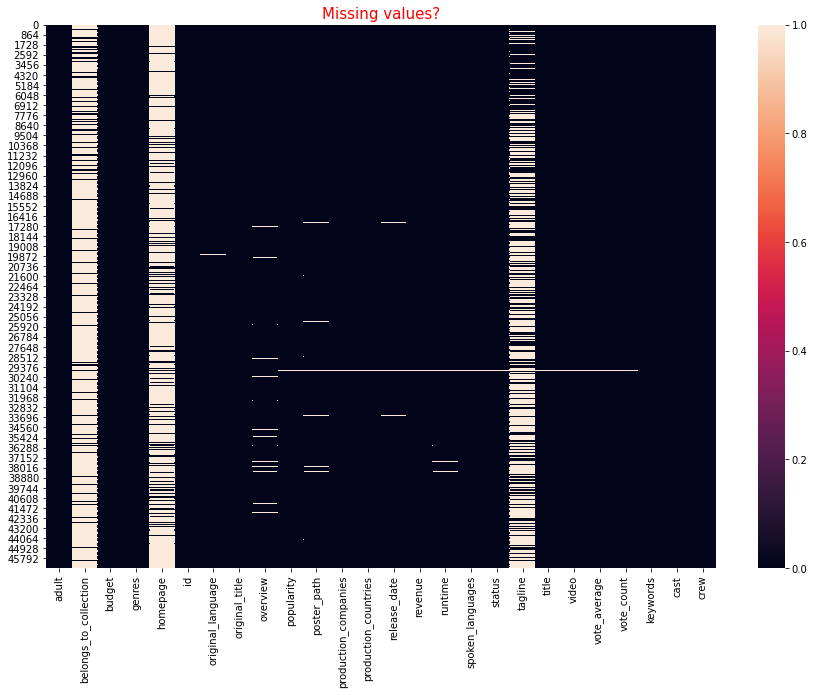

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull())
plt.title("Missing values?", fontsize = 15, color='red')
plt.show()

**Observation:**
1. Homepage and Tagline columns seems to have very large null values hence we will drop them. 
2. Belongs to collection also have large number of null values but those movies might not belong to any collection hence we will keep it.

In [ ]:
len(data[(data['status']!='Released')]) # Movies which has not been released so far

464

In [ ]:
data2 = data[(data['status']=='Released')]
data2 = data2.dropna(subset=['popularity'])

In [ ]:
data3 = data2.fillna('Not Available') # All the null values will be filled with not available

In [ ]:
data4 = data3.drop(['homepage', 'poster_path', 'tagline', 'title', 'video'], axis=1)

In [ ]:
count = 0
for title in list(data4.original_title.unique()):
    same_title_movies = data4[(data4['original_title']==title)]
    if len(same_title_movies) > 1:
        print('\033[91m' + 'Movies having the name ' + title + '\033[0m')
        display(same_title_movies)
        print('\n\n')
        count = count + 1
    if count > 10: break

Movies having the name Heat


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
5,False,Not Available,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.9249,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,7.7,1886.0,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
14856,False,Not Available,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",4579,en,Heat,"Former child star Joe Davis (Joe Dallesandro),...",0.466019,"[{'name': 'Andy Warhol Productions', 'id': 100...","[{'iso_3166_1': 'US', 'name': 'United States o...",1972-10-06,0.0,102,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.3,6.0,"[{'id': 293, 'name': 'female nudity'}, {'id': ...","[{'cast_id': 4, 'character': 'Joey', 'credit_i...","[{'credit_id': '52fe43cec3a36847f8070f75', 'de..."
29255,False,Not Available,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",42023,en,Heat,Reynolds plays an ex-soldier-of-fortunish char...,1.35223,"[{'name': 'New Century Productions', 'id': 866...","[{'iso_3166_1': 'US', 'name': 'United States o...",1986-01-01,0.0,101,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.2,5.0,[],"[{'cast_id': 4, 'character': 'Mex', 'credit_id...","[{'credit_id': '52fe45e9c3a36847f80e1adf', 'de..."





Movies having the name Sabrina


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
6,False,Not Available,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",11860,en,Sabrina,An ugly duckling having undergone a remarkable...,6.67728,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1995-12-15,0.0,127,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,6.2,141.0,"[{'id': 90, 'name': 'paris'}, {'id': 380, 'nam...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
902,False,Not Available,2238813,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6620,en,Sabrina,Linus and David Larrabee are the two sons of a...,7.35974,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1954-09-28,10000000.0,113,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,7.4,284.0,"[{'id': 380, 'name': 'brother brother relation...","[{'cast_id': 5, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe445fc3a36847f8091fb3', 'de..."





Movies having the name Sense and Sensibility


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
16,False,Not Available,16500000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",4584,en,Sense and Sensibility,"Rich Mr. Dashwood dies, leaving his second wif...",10.6732,"[{'name': 'Columbia Pictures Corporation', 'id...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-12-13,135000000.0,136,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.2,364.0,"[{'id': 420, 'name': 'bowling'}, {'id': 818, '...","[{'cast_id': 6, 'character': 'Marianne Dashwoo...","[{'credit_id': '52fe43cec3a36847f807101f', 'de..."
28580,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}]",315010,en,Sense and Sensibility,This is the acclaimed 2008 BBC adaptation of t...,1.72444,"[{'name': 'BBC Worldwide', 'id': 3164}, {'name...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2008-01-01,0.0,174,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.9,19.0,[],"[{'cast_id': 1, 'character': 'Elinor Dashwood'...","[{'credit_id': '54a48c469251411860005dac', 'de..."
41989,False,Not Available,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",391934,en,Sense and Sensibility,Two sisters of opposing temperaments find love...,0.416171,[{'name': 'British Broadcasting Corporation (B...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1981-02-01,0.0,174,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,0.0,0.0,"[{'id': 392, 'name': 'england'}, {'id': 7564, ...","[{'cast_id': 0, 'character': 'Elinor Dashwood'...","[{'credit_id': '5707bbcb9251412b0e002ac9', 'de..."
42208,False,Not Available,0,[],243987,en,Sense and Sensibility,Adaptation of the Jane Austen novel.,0.010759,[],[],1971-01-01,0.0,178,[],Released,0.0,0.0,[],"[{'cast_id': 1, 'character': 'Elinor', 'credit...","[{'credit_id': '52fe4ee8c3a36847f82afeff', 'de..."





Movies having the name Othello


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
25,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}]",16420,en,Othello,The evil Iago pretends to be friend of Othello...,1.8459,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",1995-12-15,0.0,123,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.0,33.0,"[{'id': 497, 'name': 'shakespeare'}, {'id': 93...","[{'cast_id': 2, 'character': 'Othello', 'credi...","[{'credit_id': '5462510ec3a368082d000121', 'de..."
2760,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",47697,en,Othello,"Desdemona, daughter of a Venetian aristocrat, ...",2.69859,"[{'name': 'Les Films Marceau', 'id': 2260}, {'...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1951-11-27,0.0,90,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,35.0,"[{'id': 497, 'name': 'shakespeare'}, {'id': 11...","[{'cast_id': 5, 'character': 'Othello', 'credi...","[{'credit_id': '52fe4740c3a36847f812b8d3', 'de..."
15518,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}]",44006,en,Othello,The 1965 version of the Shakespeare play.,0.377325,"[{'name': 'BHE Films', 'id': 2008}, {'name': '...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1965-12-15,0.0,165,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,9.0,"[{'id': 497, 'name': 'shakespeare'}, {'id': 96...","[{'cast_id': 2, 'character': 'Othello', 'credi...","[{'credit_id': '52fe4671c3a36847f80ff483', 'de..."
21473,False,Not Available,0,[],119928,en,Othello,Iago and a comrade-in-arms are outside the Ven...,0.653579,[],[],1981-10-04,0.0,204,[],Released,9.5,2.0,[],"[{'cast_id': 1, 'character': '', 'credit_id': ...","[{'credit_id': '52fe4c10c3a36847f821fd17', 'de..."





Movies having the name Persuasion


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
27,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",17015,en,Persuasion,This film adaptation of Jane Austen's last nov...,2.22843,"[{'name': 'BBC Films', 'id': 288}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-09-27,0.0,104,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.4,36.0,"[{'id': 1316, 'name': 'captain'}, {'id': 33384...","[{'cast_id': 1, 'character': 'Anne Elliott', '...","[{'credit_id': '52fe46ff9251416c7508a8b3', 'de..."
15010,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",13949,en,Persuasion,Persuasion is the newest adaptation of the cla...,6.95584,"[{'name': 'WGBH', 'id': 3449}, {'name': 'Clerk...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2007-04-01,0.0,93,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.1,52.0,"[{'id': 128, 'name': 'love triangle'}, {'id': ...","[{'cast_id': 1, 'character': 'Anne Elliot', 'c...","[{'credit_id': '53569438c3a3687f1e00007e', 'de..."
42003,False,Not Available,0,[],243984,en,Persuasion,Adaptation of the Jane Austen novel.,0.001459,[],[],1971-01-01,0.0,300,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,0.0,0.0,[],"[{'cast_id': 1, 'character': 'Anne Elliot', 'c...","[{'credit_id': '598dd6b6c3a3687559015d56', 'de..."





Movies having the name It Takes Two


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
37,False,Not Available,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",33689,en,It Takes Two,Identical 9-year-olds from very different back...,7.77774,"[{'name': 'Dualstar Productions', 'id': 6130},...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-11-17,0.0,101,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,149.0,"[{'id': 13014, 'name': 'orphan'}, {'id': 20435...","[{'cast_id': 1, 'character': 'Diane Barrows', ...","[{'credit_id': '52fe45309251416c9102a49d', 'de..."
29342,False,Not Available,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",110538,en,It Takes Two,Travis is due to marry Stephanie in a few days...,0.00243,"[{'name': 'United Artists', 'id': 60}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1988-07-13,0.0,78,[],Released,5.4,5.0,[],"[{'cast_id': 2, 'character': 'Travis Rogers', ...","[{'credit_id': '52fe4adbc3a36847f81e551d', 'de..."





Movies having the name Cry, the Beloved Country


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
39,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}]",34615,en,"Cry, the Beloved Country",A South-African preacher goes to search for hi...,0.894647,"[{'name': 'Miramax', 'id': 53009}, {'name': 'D...","[{'iso_3166_1': 'ZA', 'name': 'South Africa'}]",1995-12-15,676525.0,106,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.7,13.0,"[{'id': 3644, 'name': 'south africa'}]","[{'cast_id': 4, 'character': 'Rev. Stephen Kum...","[{'credit_id': '52fe456f9251416c91032375', 'de..."
26881,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}]",173893,en,"Cry, the Beloved Country","In the back country of South Africa, black min...",0.691117,"[{'name': 'London Film Productions', 'id': 659}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1952-04-26,0.0,103,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.7,3.0,[],"[{'cast_id': 1, 'character': 'Stephen Kumalo',...","[{'credit_id': '52fe4d3ec3a36847f82566f3', 'de..."





Movies having the name Richard III


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
40,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",31174,en,Richard III,Shakespeare's Play transplanted into a 1930s s...,4.56139,"[{'name': 'British Screen', 'id': 871}, {'name...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1995-12-29,0.0,104,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.9,50.0,"[{'id': 392, 'name': 'england'}, {'id': 497, '...","[{'cast_id': 1, 'character': 'Richard III', 'c...","[{'credit_id': '52fe44669251416c9100f5a3', 'de..."
7254,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",43323,en,Richard III,Shakespeare's powerful tale of the wicked defo...,1.97128,"[{'name': 'London Film Productions', 'id': 659...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1955-12-13,0.0,161,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.8,26.0,"[{'id': 497, 'name': 'shakespeare'}]","[{'cast_id': 3, 'character': 'King Edward IV o...","[{'credit_id': '52fe463dc3a36847f80f413d', 'de..."
17909,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}]",46758,en,Richard III,Shakespeare's tragedy of the hump-backed Duke ...,0.05131,"[{'name': ""Le Film d'Art"", 'id': 1573}, {'name...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1912-10-15,0.0,55,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,0.0,1.0,[],"[{'cast_id': 10, 'character': 'King Edward IV'...","[{'credit_id': '570e9e78c3a368538b000432', 'de..."





Movies having the name Restoration


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
42,False,Not Available,19000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",35196,en,Restoration,"An aspiring young physician, Robert Merivel fo...",10.9793,"[{'name': 'Miramax Films', 'id': 14}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-29,0.0,117,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.3,30.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 1279,...","[{'cast_id': 1, 'character': 'Robert Merivel',...","[{'credit_id': '52fe45999251416c91037fdf', 'de..."
39740,False,Not Available,0,"[{'id': 27, 'name': 'Horror'}]",396152,en,Restoration,"During home renovations, a young couple releas...",1.074124,[],[],2016-05-03,0.0,90,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.3,11.0,[],"[{'cast_id': 3, 'character': 'Rebecca Jordan',...","[{'credit_id': '572bd470c3a368013d0002b1', 'de..."





Movies having the name Lamerica


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
52,False,Not Available,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...",49133,it,Lamerica,"Fiore, an Italian conman, arrives in post Comm...",1.36129,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...",1994-01-01,0.0,116,"[{'iso_639_1': 'sq', 'name': 'shqip'}, {'iso_6...",Released,7.7,11.0,"[{'id': 10183, 'name': 'independent film'}]","[{'cast_id': 2, 'character': 'Gino', 'credit_i...","[{'credit_id': '52fe4787c3a36847f813acf7', 'de..."
39373,False,Not Available,0,[],384237,en,Lamerica,Lamerica is a cinematic documentary that takes...,0.040155,[],"[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...",2015-10-15,0.0,43,[],Released,0.0,0.0,[],[],"[{'credit_id': '56cc258e9251412452001fe5', 'de..."





Movies having the name Home for the Holidays


,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,keywords,cast,crew
56,False,Not Available,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",9089,en,Home for the Holidays,"After losing her job, making out with her soon...",8.4168,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-11-02,17519169.0,103,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.3,39.0,"[{'id': 2672, 'name': 'baltimore'}, {'id': 454...","[{'cast_id': 10, 'character': 'Claudia Larson'...","[{'credit_id': '52fe44dac3a36847f80ae00b', 'de..."
33785,False,Not Available,0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",30933,en,Home for the Holidays,An ailing man summons his four daughters home ...,0.984071,"[{'name': 'ABC Circle Films', 'id': 2166}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1974-07-13,0.0,73,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,3.0,"[{'id': 351, 'name': 'poison'}, {'id': 1156, '...","[{'cast_id': 10, 'character': 'Frederica Morga...","[{'credit_id': '52fe444c9251416c9100bc95', 'de..."


In [ ]:
print(data4.shape)
data5 = data4.drop_duplicates(subset=['original_title'], keep='first') # In most cases first movie among same name movies has the highest popularity hence we will keep them
print(data5.shape)

(46164, 21)
(42955, 21)


In [ ]:
data6 = data5
data6['release_date'] = data6['release_date'].apply(lambda x: x.split('-')[0])
data6 = data6.rename(index=str, columns={'release_date':'year'})

In [ ]:
data6.production_companies[5]

"[{'name': 'Regency Enterprises', 'id': 508}, {'name': 'Forward Pass', 'id': 675}, {'name': 'Warner Bros.', 'id': 6194}]"

In [ ]:
data6['cast'][2564]

'[{\'cast_id\': 1, \'character\': \'Mike\', \'credit_id\': \'52fe46ad9251416c7507feb3\', \'gender\': 2, \'id\': 4987, \'name\': \'Omar Epps\', \'order\': 0, \'profile_path\': \'/t4Qg5ANKK2idfOt4RzWzhiP7IEv.jpg\'}, {\'cast_id\': 2, \'character\': \'Slim\', \'credit_id\': \'52fe46ad9251416c7507feb7\', \'gender\': 2, \'id\': 55755, \'name\': \'Richard T. Jones\', \'order\': 1, \'profile_path\': \'/ccELAB9yHvG4OxG8dURdUXznwJ8.jpg\'}, {\'cast_id\': 4, \'character\': \'Roland\', \'credit_id\': \'52fe46ad9251416c7507febf\', \'gender\': 2, \'id\': 17637, \'name\': \'Taye Diggs\', \'order\': 2, \'profile_path\': \'/1g1demRAGhwdUpwi8PA0wgFe2IX.jpg\'}, {\'cast_id\': 3, \'character\': \'Young Alicia\', \'credit_id\': \'52fe46ad9251416c7507febb\', \'gender\': 1, \'id\': 74612, \'name\': \'Malinda Williams\', \'order\': 3, \'profile_path\': \'/hx4vstXwizQOSuFQ8awWO7fcR7Y.jpg\'}, {\'cast_id\': 5, \'character\': \'Young Mike\', \'credit_id\': \'52fe46ad9251416c7507fec3\', \'gender\': 2, \'id\': 75601,

In [ ]:
data6['crew'][0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

In [ ]:
data6['keywords'][0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

In [ ]:
data5['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [ ]:
import re # import Regular Expression

data7 = data6

data7['popularity'] = data7['popularity'].apply(lambda x: float(x))

data7['budget'] = data7['budget'].apply(lambda x: x if x != 0 else 'Not Available')

data7['belongs_to_collection'] = data7['belongs_to_collection'].apply(lambda x: x.split(': ')[2].split(',')[0][1:-1] if x != 'Not Available' else ' ')

pattern = ",\s'name':\s'([A-z\s]+)"
data7['genres'] = data7['genres'].apply(lambda x: ' '.join([w for w in re.findall(pattern, x)]) if len(re.findall(pattern, x)) != 0 else ' ')

pattern = "{'name':\s'([A-z\s]+)',\s'"
data7['production_companies'] = data7['production_companies'].apply(lambda x: ' '.join([w for w in re.findall(pattern, x)]))

data7['production_countries'] = data7['production_countries'].apply(lambda x: ' '.join([w for w in re.findall('[A-Z][A-Z]', x)]) if len(re.findall('[A-Z][A-Z]', x)) else ' ')

pattern = ",\s'name':\s'([A-z\s]+)"
data7['cast'] = data7['cast'].apply(lambda x: ' '.join([w for w in re.findall(pattern, x)[0:3]]))

pattern = ":\s\'Director\',\s\'name\':\s\'([A-z\s]+)"
data7['director'] = data7['crew'].apply(lambda x: re.findall(pattern, x)[0] if len(re.findall(pattern, x)) != 0 else ' ') 
data7 = data7.drop(['crew', 'spoken_languages'], axis=1)

pattern = ",\s'name':\s'([A-z\s]+)"
data7['keywords'] = data7['keywords'].apply(lambda x: ' '.join([w for w in re.findall(pattern, x)]))

data7.head()

,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,year,revenue,runtime,status,vote_average,vote_count,keywords,cast,director
0,False,Toy Story Collection,30000000,Animation Comedy Family,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,US,1995,373554033.0,81,Released,7.7,5415.0,jealousy toy boy friendship friends rivalry bo...,Tom Hanks Tim Allen Don Rickles,John Lasseter
1,False,,65000000,Adventure Fantasy Family,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,TriStar Pictures Teitler Film Interscope Commu...,US,1995,262797249.0,104,Released,6.9,2413.0,board game disappearance new home recluse gian...,Robin Williams Jonathan Hyde Kirsten Dunst,Joe Johnston
2,False,Grumpy Old Men Collection,0,Romance Comedy,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,Lancaster Gate,US,1995,0.0,101,Released,6.5,92.0,fishing best friend duringcreditsstinger old men,Walter Matthau Jack Lemmon Ann,Howard Deutch
3,False,,16000000,Comedy Drama Romance,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,US,1995,81452156.0,127,Released,6.1,34.0,based on novel interracial relationship single...,Whitney Houston Angela Bassett Loretta Devine,Forest Whitaker
4,False,Father of the Bride Collection,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,Sandollar Productions Touchstone Pictures,US,1995,76578911.0,106,Released,5.7,173.0,baby midlife crisis confidence aging daughter ...,Steve Martin Diane Keaton Martin Short,Charles Shyer


In [ ]:
language_stats = data7['original_language'].value_counts(ascending=False)
language_stats

en    30136
fr     2351
it     1499
ja     1326
de     1038
      ...  
cy        1
uz        1
tg        1
rw        1
si        1
Name: original_language, Length: 89, dtype: int64

In [ ]:
small_movie_collections_by_language = language_stats[language_stats<300] 
data7.original_language = data7.original_language.apply(lambda x: 'other' if x in small_movie_collections_by_language else x)
data8 = data7[data7.original_language!='other']
len(data7.original_language.unique())

14

In [ ]:
major_languages = list(data8.original_language.unique())
print(major_languages)

['en', 'fr', 'zh', 'it', 'de', 'cn', 'es', 'ru', 'sv', 'ja', 'ko', 'pt', 'hi']


In [ ]:
pip install googletrans

     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 38.4 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=207e8b4f773b11af6661fd71c5608e50159cf7fdb078c5c087c9fd3f19c66a8d
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


In [ ]:
import googletrans

univ_lang = googletrans.LANGUAGES
print(univ_lang)

{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'he': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgyz', 'lo': 'lao', 'la': 'lat

In [ ]:
data9 = data8
data9['original_language'] = data9['original_language'].apply(lambda x: 'zh-cn' if x =='zh' else x)
data9['original_language'] = data9['original_language'].apply(lambda x: 'zh-cn' if x =='cn' else x)

data9['original_language'] = data9['original_language'].apply(lambda x: univ_lang[x])

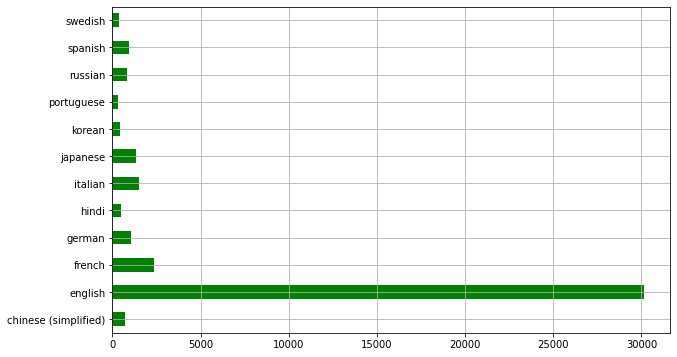

In [ ]:
data9['original_language'].value_counts(dropna=True).sort_index().plot(kind='barh',figsize=(10,6), color='green')
plt.grid()
plt.show()

In [ ]:
data9['New_genre'] = data9.genres.apply(lambda x: [(i+' ')*((3)-re.findall('[A-z]+', x).index(i)) for i in re.findall('[A-z]+', x)])
data9['New_genre'] = data9['New_genre'].apply(lambda x: ' '.join([w for w in x]))

In [ ]:
# function to plot most frequent terms
import nltk # Natural language processing toolkit
from nltk import FreqDist # Frequency distribution

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 30 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    ax.set(xlabel = 'Words')
    plt.title('Most Common Words', weight='bold', fontsize=12)
    plt.show()

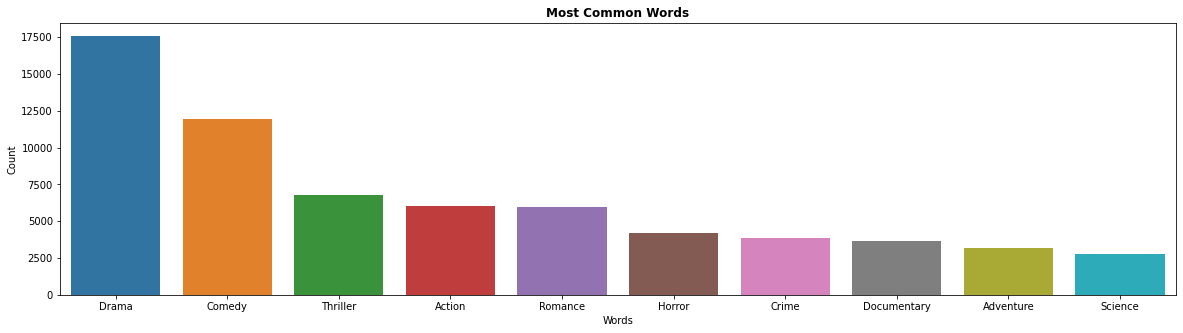

In [ ]:
freq_words(data9['genres'], 10)

In [ ]:
# Using wordcloud to visually represent the text data
def wordcloud_draw(data1, color1 = 'black'):
    words1 = ' '.join(data1)
    cleaned_word1 = " ".join([word for word in words1.split(' ')
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color=color1,
                      width=2500,
                      height=2000
                      ).generate(cleaned_word1)


    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.title('Genres', weight='bold', fontsize=20)
    plt.imshow(wordcloud1)
    plt.show()

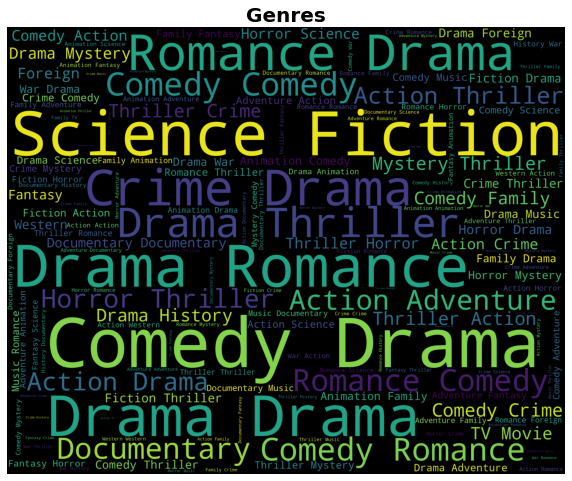

In [ ]:
wordcloud_draw(list(data9['genres'].values))

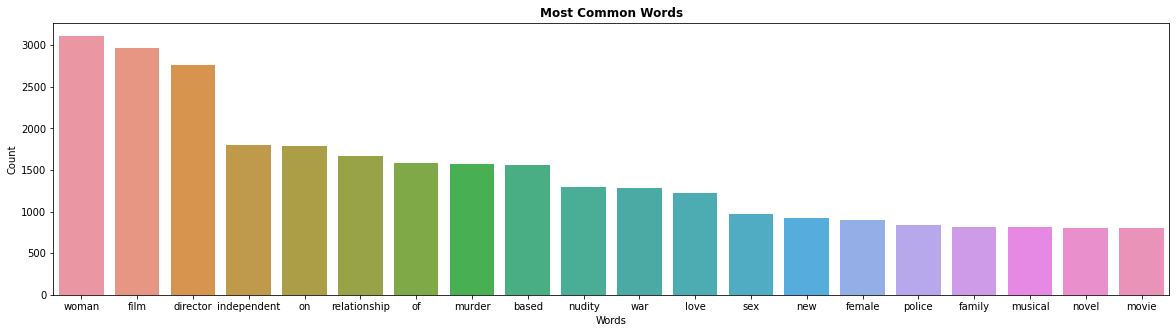

In [ ]:
freq_words(data9['keywords'], 20)

In [ ]:
data9[data9['original_language']=='english'].sort_values('popularity', ascending=False).head(50)

,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,year,revenue,runtime,status,vote_average,vote_count,keywords,cast,director,New_genre
30910,False,Despicable Me Collection,74000000,Family Animation Adventure Comedy,211672,english,Minions,"Minions Stuart, Kevin and Bob are recruited by...",547.488298,Universal Pictures Illumination Entertainment,US,2015,1.156731e+09,91,Released,6.4,4729.0,assistant aftercreditsstinger duringcreditssti...,Sandra Bullock Jon Hamm Michael Keaton,Kyle Balda,Family Family Family Animation Animation Adv...
44809,False,,34000000,Action Crime,339403,english,Baby Driver,After being coerced into working for a crime b...,228.032744,Big Talk Productions TriStar Pictures Media Ri...,GB US,2017,2.245113e+08,113,Released,7.2,2083.0,robbery atlanta music crime boss romance tinni...,Ansel Elgort Lily James Kevin Spacey,Edgar Wright,Action Action Action Crime Crime
24657,False,,165000000,Adventure Family Animation Action Comedy,177572,english,Big Hero 6,The special bond that develops between plus-si...,213.849907,Walt Disney Pictures Walt Disney Animation Stu...,US,2014,6.521054e+08,102,Released,7.8,6289.0,brother brother relationship hero talent reven...,Scott Adsit Ryan Potter Daniel Henney,Chris Williams,Adventure Adventure Adventure Family Family ...
26779,False,Deadpool Collection,58000000,Action Adventure Comedy,293660,english,Deadpool,Deadpool tells the origin story of former Spec...,187.860492,Twentieth Century Fox Film Corporation Marvel ...,US,2016,7.831130e+08,108,Released,7.4,11444.0,anti hero mercenary marvel comic superhero bas...,Ryan Reynolds Morena Baccarin Ed Skrein,Tim Miller,Action Action Action Adventure Adventure Com...
26781,False,Guardians of the Galaxy Collection,200000000,Action Adventure Comedy Science Fiction,283995,english,Guardians of the Galaxy Vol. 2,The Guardians must fight to keep their newfoun...,185.330992,Walt Disney Pictures Marvel Studios,US,2017,8.634161e+08,137,Released,7.6,4858.0,sequel superhero based on comic misfit space o...,Chris Pratt Zoe Saldana Dave Bautista,James Gunn,Action Action Action Adventure Adventure Com...
14723,False,Avatar Collection,237000000,Action Adventure Fantasy Science Fiction,19995,english,Avatar,"In the 22nd century, a paraplegic Marine is di...",185.070892,Ingenious Film Partners Twentieth Century Fox ...,US GB,2009,2.787965e+09,162,Released,7.2,12114.0,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver,James Cameron,Action Action Action Adventure Adventure Fan...
24553,False,John Wick Collection,20000000,Action Thriller,245891,english,John Wick,Ex-lunatic John Wick comes off his meds to tra...,183.870374,Summit Entertainment DefyNite Films MJW Films,CA CN US,2014,8.876166e+07,101,Released,7.0,5499.0,hitman russian mafia revenge murder gangster d...,Keanu Reeves Michael Nyqvist Alfie Allen,Chad Stahelski,Action Action Action Thriller Thriller
23870,False,,61000000,Mystery Thriller Drama,210577,english,Gone Girl,With his wife's disappearance having become th...,154.801009,Twentieth Century Fox Film Corporation Regency...,US,2014,3.693304e+08,145,Released,7.9,6023.0,based on novel marriage crisis disappearance c...,Ben Affleck Rosamund Pike Carrie Coon,David Fincher,Mystery Mystery Mystery Thriller Thriller Dr...
25074,False,The Hunger Games Collection,125000000,Science Fiction Adventure Thriller,131631,english,The Hunger Games: Mockingjay - Part 1,Katniss Everdeen reluctantly becomes the symbo...,147.098006,Lionsgate Color Force,US,2014,7.521002e+08,123,Released,6.6,5767.0,resistance post dystopia war sequel female pro...,Jennifer Lawrence Josh Hutcherson Liam Hemsworth,Francis Lawrence,Science Science Science Fiction Fiction Adve...
45439,False,Planet of the Apes (Reboot) Collection,152000000,Drama Science Fiction War,281338,english,War for the Planet of the Apes,Caesar and his apes are forced into a deadly c

In [ ]:
data9[(data9['original_title']=='Now You See Me 2')]['New_genre'][0]

'Action Action Action  Adventure Adventure  Comedy    '

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def recommendations(title, df= data9):
    
    lang = df[(df['original_title']==title)]['original_language'].iloc[0]
    
    if lang != 'english':
        data = df[(df['original_language']==lang)]
    else:
        data = df[(df['original_language']==lang)]
        data = data[(data['popularity'] > 1.3)]
        data = data[(data['vote_count'] >= 50)]

    def combined_feature(row):
        return row['belongs_to_collection']+' '+row['New_genre']+' '+row['overview']+' '+row['cast']+' '+row['director']+' '+row['keywords']+' '+row['original_title']
    
    data['combined_features'] = data.apply(combined_feature, axis=1)
    data['combined_features'] = data['combined_features'].apply(lambda x: ' '.join([w.lower() for w in x.split(' ')]))

    import nltk
    from nltk.corpus import stopwords
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    stopset = set(stopwords.words('english'))
    vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, strip_accents='ascii', stop_words=stopset)
    count_matrix = vectorizer.fit_transform(data.combined_features)
    cosine_sim = cosine_similarity(count_matrix)

    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)

    data.reset_index(inplace=True)
    indices = pd.Series(data.index, index = data['original_title']).drop_duplicates()

    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores.sort(key=lambda x: x[1], reverse= True)
    sim_scores = sim_scores[1:50]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = data.iloc[movie_indices][['original_title', 'vote_count', 'vote_average', 'year', 'genres', 'original_language']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average']
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)

    qualified = movies
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average']
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)

    del cosine_sim

    return qualified.iloc[0:10,:].sort_values('wr', ascending=False)

recommendations("Iron Man")

,original_title,vote_count,vote_average,year,genres,original_language,wr
6035,Avengers: Age of Ultron,6908,7.3,2015,Action Adventure Science Fiction,english,6.978926
6040,Captain America: Civil War,7462,7.1,2016,Adventure Action Science Fiction,english,6.863088
6037,Ant-Man,6029,7.0,2015,Science Fiction Action Adventure,english,6.768041
5333,Iron Man 3,8951,6.8,2013,Action Adventure Science Fiction,english,6.681384
4509,Iron Man 2,6969,6.6,2010,Adventure Action Science Fiction,english,6.531324
6832,Marvel One-Shot: All Hail the King,102,7.0,2014,Comedy Action Drama Thriller Fantasy,english,6.423301
6884,Marvel One-Shot: A Funny Thing Happened on the...,72,7.0,2011,Science Fiction Fantasy,english,6.418929
6123,Marvel One-Shot: Item 47,114,6.6,2012,Science Fiction Action Fantasy,english,6.413631
6833,Marvel One-Shot: The Consultant,108,6.6,2011,Adventure Fantasy Science Fiction Action,english,6.413351
4005,The Incredible Hulk,3086,6.1,2008,Science Fiction Action Adventure,english,6.271762
